<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/bayes_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Statistics 

In this notebook, we illustrate some basic concepts in (computaitonal) Bayesian statistics. We borrow some code examples from chapter 2 of [Bayesian Analysis with Python (2nd end)](https://github.com/aloctavodia/BAP) by Osvaldo Martin.




* The primary goal is to infer the posterior of the parameters $\theta$ of some model given observations or data $D=(y_1,\ldots,y_n)$:
$$
p(\theta|D) = \frac{p(\theta) p(D|\theta)}{p(D)}
$$
* If we assume the observations are independently sampled and identically distributed (iid), then we can write the likelihood as
$$
p(D|\theta) = \prod_{n=1}^N p(y_n|\theta)
$$
* If we have features, we can fit a conditional or discriminative model of the form $p(y|x;\theta)$, where the model generates the output $y$ given the input $x$. In this case, the likelihood becomes 
$$
p(D|\theta) = \prod_{n=1}^N p(y_n|x_n;\theta)
$$

In [ ]:
%matplotlib inline
import sklearn
import scipy.stats as stats
import scipy.optimize
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
import os
import pandas as pd


In [ ]:
# We install various packages  we will need

# The PyMC3 package (https://docs.pymc.io) supports HMC and variational inference
# https://docs.pymc.io/notebooks/api_quickstart.html
#Installed version of ArviZ requires PyMC3>=3.8
!pip install pymc3==3.8
#!pip install pymc3>=3.8 # does not work
import pymc3 as pm
pm.__version__

# The arviz package (https://github.com/arviz-devs/arviz) can be used to make various plots
# of posterior samples generated by any algorithm. 
!pip install arviz
import arviz as az

     |████████████████████████████████| 911kB 6.7MB/s 
     |████████████████████████████████| 1.5MB 21.2MB/s 
     |████████████████████████████████| 737kB 41.7MB/s 
     |████████████████████████████████| 4.7MB 45.2MB/s 
     |████████████████████████████████| 296kB 47.4MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


# Beta-Binomial model



## Exact inference

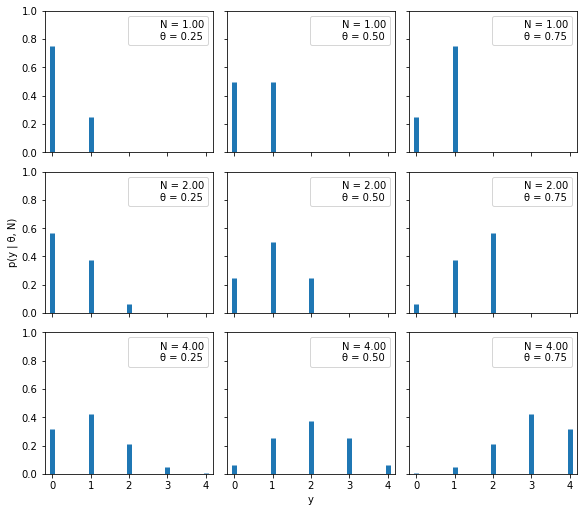

In [ ]:
# Plot the Binomial likelihood

n_params = [1, 2, 4]  # Number of trials
p_params = [0.25, 0.5, 0.75]  # Probability of success

x = np.arange(0, max(n_params)+1)
f,ax = plt.subplots(len(n_params), len(p_params), sharex=True, sharey=True,
                    figsize=(8, 7), constrained_layout=True)

for i in range(len(n_params)):
    for j in range(len(p_params)):
        n = n_params[i]
        p = p_params[j]

        y = stats.binom(n=n, p=p).pmf(x)

        ax[i,j].vlines(x, 0, y, colors='C0', lw=5)
        ax[i,j].set_ylim(0, 1)
        ax[i,j].plot(0, 0, label="N = {:3.2f}\nθ = {:3.2f}".format(n,p), alpha=0)
        ax[i,j].legend()

        ax[2,1].set_xlabel('y')
        ax[1,0].set_ylabel('p(y | θ, N)')
        ax[0,0].set_xticks(x)


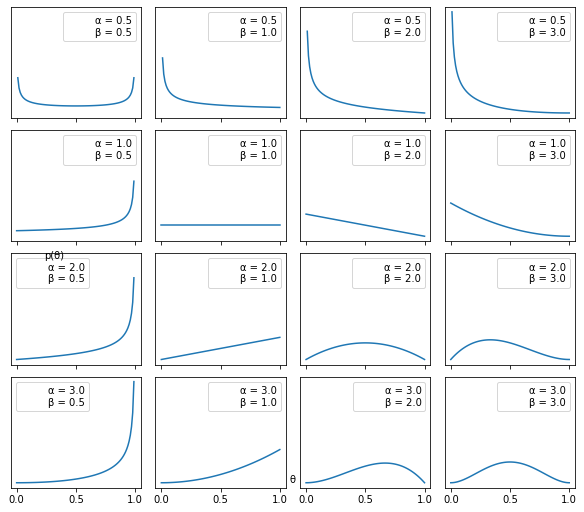

In [ ]:
# Plot the beta prior

params = [0.5, 1, 2, 3]
x = np.linspace(0, 1, 100)
f, ax = plt.subplots(len(params), len(params), sharex=True, sharey=True,
                     figsize=(8, 7), constrained_layout=True)
for i in range(4):
    for j in range(4):
        a = params[i]
        b = params[j]
        y = stats.beta(a, b).pdf(x)
        ax[i,j].plot(x, y)
        ax[i,j].plot(0, 0, label="α = {:2.1f}\nβ = {:2.1f}".format(a, b), alpha=0)
        ax[i,j].legend()
ax[1,0].set_yticks([])
ax[1,0].set_xticks([0, 0.5, 1])
f.text(0.5, 0.05, 'θ', ha='center')
f.text(0.07, 0.5, 'p(θ)', va='center', rotation=0)


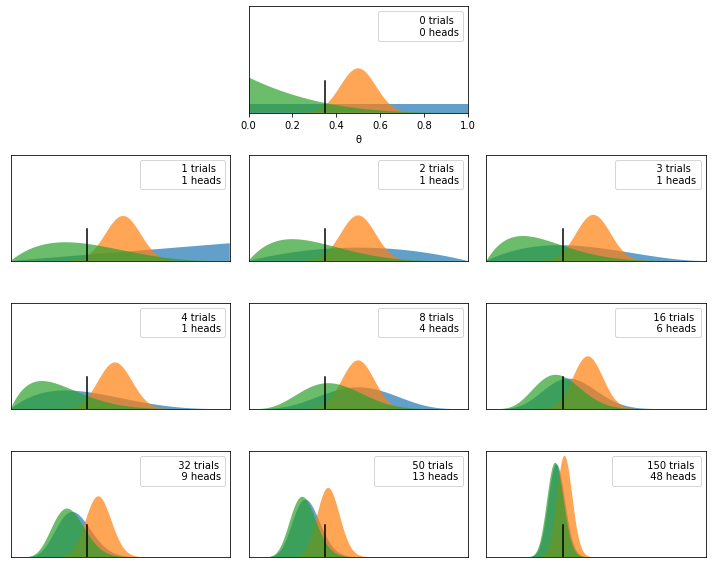

In [ ]:
# Compute and plot posterior (black vertical line = true parameter value)

plt.figure(figsize=(10, 8))

n_trials = [0, 1, 2, 3, 4, 8, 16, 32, 50, 150]
data = [0, 1, 1, 1, 1, 4, 6, 9, 13, 48]
theta_real = 0.35

beta_params = [(1, 1), (20, 20), (1, 4)]
dist = stats.beta
x = np.linspace(0, 1, 200)

for idx, N in enumerate(n_trials):
    if idx == 0:
        plt.subplot(4, 3, 2)
        plt.xlabel('θ')
    else:
        plt.subplot(4, 3, idx+3)
        plt.xticks([])
    y = data[idx]
    for (a_prior, b_prior) in beta_params:
        p_theta_given_y = dist.pdf(x, a_prior + y, b_prior + N - y)
        plt.fill_between(x, 0, p_theta_given_y, alpha=0.7)

    plt.axvline(theta_real, ymax=0.3, color='k')
    plt.plot(0, 0, label=f'{N:4d} trials\n{y:4d} heads', alpha=0)
    plt.xlim(0, 1)
    plt.ylim(0, 12)
    plt.legend()
    plt.yticks([])
plt.tight_layout()


## Credible intervals <a class="anchor" id="credible"></a>




In [ ]:
# We illustrate how to compute a 95% posterior credible interval for a random variable
# with a beta distribution.

from scipy.stats import beta

np.random.seed(42)
theta_real = 0.35
ntrials = 100
data = stats.bernoulli.rvs(p=theta_real, size=ntrials)

N = ntrials; N1 = sum(data); N0 = N-N1; # Sufficient statistics
aprior = 1; bprior = 1; # prior
apost = aprior + N1; bpost = bprior + N0 # posterior

# Interval function
alpha = 0.05
CI1 = beta.interval(1-alpha, apost, bpost)
print('{:0.2f}--{:0.2f}'.format(CI1[0], CI1[1])) # (0.06:0.52) 

# Use the inverse CDF (percent point function)
l  = beta.ppf(alpha/2, apost, bpost)
u  = beta.ppf(1-alpha/2, apost, bpost)
CI2 = (l,u)
print('{:0.2f}--{:0.2f}'.format(CI2[0], CI2[1])) # (0.06:0.52) 

# Use Monte Carlo sampling
samples = beta.rvs(apost, bpost, size=10000)
samples = np.sort(samples)
CI3 = np.percentile(samples, 100*np.array([alpha/2, 1-alpha/2])) 
print('{:0.2f}--{:0.2f}'.format(CI3[0], CI3[1])) # (0.06:0.51) 
print(np.mean(samples))


0.24--0.42
0.24--0.42
0.24--0.42
0.3230834644012448


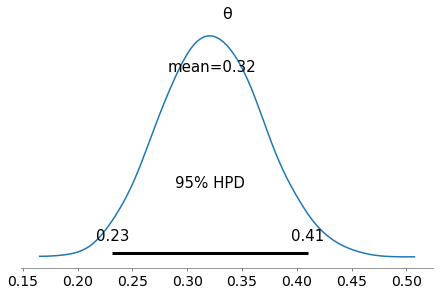

In [ ]:
# Use arviz to plot posterior.
# By default, it shows the 94\% interval, but we change it to 95%.

az.plot_posterior({'θ':samples}, credible_interval=0.95);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc227f147b8>],
      dtype=object)

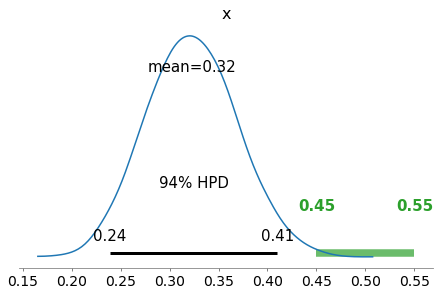

In [ ]:
# See if the parameter is inside the region of practical equivalence centered at 0.5
az.plot_posterior(samples, rope=[0.45, .55]);

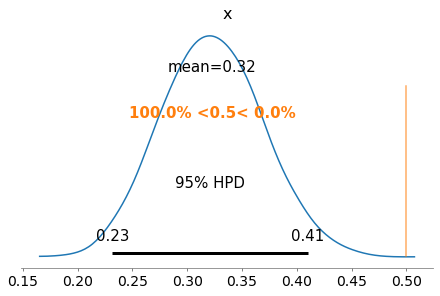

In [ ]:
# From the above plot, we see that the HPD does not overlap the ROPE,
#so we can confidently say the parameter is "significiantly different" from 0.5

# We can also verify this by checking if 0.5 is in the HPD
az.plot_posterior(samples,  credible_interval=0.95, ref_val=0.5);

In [ ]:
# Summarize  posterior samples
az.summary(samples)
# We can ignore the warning about not having enough 'chains',
# since we are drawing exact iid samples from the posterior.

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,0.323,0.046,0.239,0.41,0.041,0.04,1.0,1.0,1.0,10.0,NaN


## Point estimates

We minimize the posterior expected loss, using L2 loss (estimator is posterior mean) or L1 loss (estimator is posterior median).

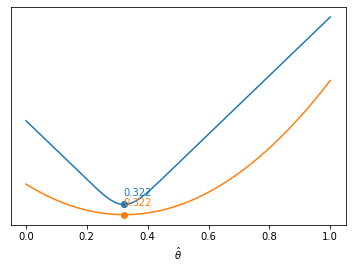

In [ ]:
grid = np.linspace(0, 1, 200)
θ_pos = samples #trace['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]

for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.3f}'.format(grid[mini]),
                 (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')

## MCMC inference 

We will use pymc3 to approximate the posterior of this simple model.
Code is based on [this notebook](https://github.com/aloctavodia/BAP/blob/master/code/Chp202%20Programming%20probabilistically.ipynb).



In [ ]:
data # same as above

array([0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0])

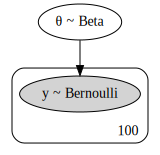

In [ ]:
with pm.Model() as model:
    # a priori
    θ = pm.Beta('θ', alpha=aprior, beta=bprior)
    # likelihood
    y = pm.Bernoulli('y', p=θ, observed=data)

pm.model_to_graphviz(model) # show the DAG

In [ ]:
# run MCMC (defaults to 2 chains)
with model:
    trace = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [θ]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:00<00:00, 1877.55it/s]


<xarray.Dataset>
Dimensions:  ()
Data variables:
    θ        float64 1.006


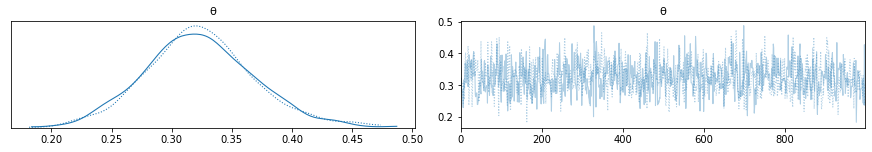

In [ ]:
 # Standard MCMC diagonistics
pm.traceplot(trace);
Rhat = pm.rhat(trace);
print(Rhat) # should be close to 1.0


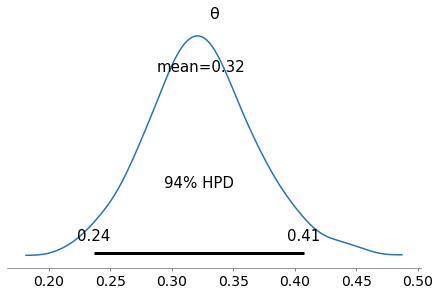

In [ ]:
pm.plot_posterior(trace);
# The samples from MCMC (called "trace") should be similar to the exact
# iid samples from the posterior, plotted above
# Under the hood, pm.plot_posterior(trace) calls az.plot_posterior(trace)

In [ ]:
# Summarize  posterior samples
pm.summary(trace)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
θ,0.324,0.045,0.237,0.407,0.002,0.001,867.0,867.0,851.0,1292.0,1.01


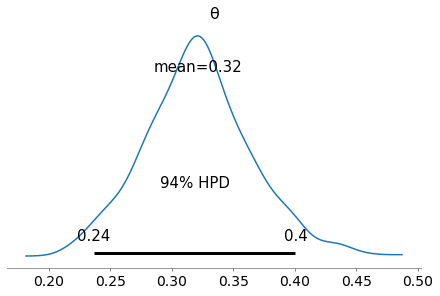

In [ ]:
# Convert posterior samples into a parametric distribution
trace_approx = pm.Empirical(trace, model=model)
# Now plot samples from this distribution
az.plot_posterior(trace_approx.sample(1000));

## Variational inference 

We use automatic differentiation VI.
Details can be found at https://docs.pymc.io/notebooks/variational_api_quickstart.html

In [ ]:
niter = 10000
with model:
    post = pm.fit(niter, method='advi'); # mean field approximation


Average Loss = 64.881: 100%|██████████| 10000/10000 [00:03<00:00, 2560.06it/s]
Finished [100%]: Average Loss = 64.882


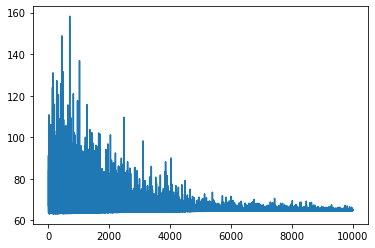

In [ ]:
# Plot negative ELBO vs iteration to assess convergence
plt.plot(post.hist);

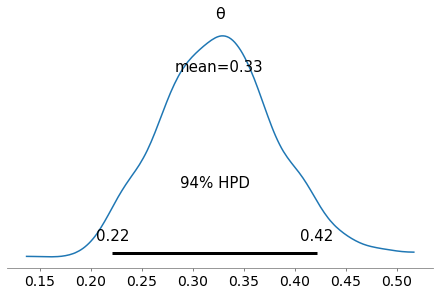

In [ ]:
pm.plot_posterior(post.sample(1000));

# 1d Gaussian 

## Exact inference

For simplicity, we assume the variance is known, and we just want to infer the mean.

In [ ]:
np.random.seed(0)
N = 100
x = np.random.randn(100)

# Parameters of prior
mu_prior = 1.1
sigma_prior = 1.2 #std
Sigma_prior = sigma_prior**2 #var

# Parameters of likelihood
sigma_x = 1.3
Sigma_x = sigma_x**2

# Bayes rule for Gaussians 
Sigma_post = 1/( 1/Sigma_prior + N/Sigma_x )
xbar = np.mean(x)
mu_post = Sigma_post * (1/Sigma_x * N * xbar + 1/Sigma_prior * mu_prior);
print('p(mu|D)=N(mu|{:.3f}, {:.3f})'.format(mu_post, Sigma_post))


p(\mu|D)=N(mu|0.072, 0.017)


## MCMC inference

Initially we assume the variance is known, so we can compare results to exact infernece.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:00<00:00, 1957.38it/s]
The acceptance probability does not match the target. It is 0.8864843167489614, but should be close to 0.8. Try to increase the number of tuning steps.


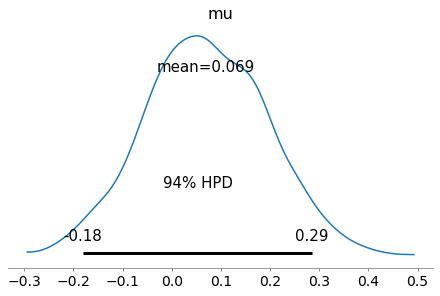

In [ ]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=mu_prior, sd=sigma_prior)
    obs = pm.Normal('obs', mu=mu, sd=sigma_x, observed=x)
    mcmc_samples = pm.sample(1000, tune=500) # mcmc
    
pm.plot_posterior(mcmc_samples);


In [ ]:
vals = mcmc_samples.get_values('mu')
mu_post_mcmc = np.mean(vals)
Sigma_post_mcmc = np.var(vals)
print('pMCMC(mu|D)=N(mu|{:.3f}, {:.3f})'.format(mu_post_mcmc, Sigma_post_mcmc))
assert np.isclose(mu_post, mu_post_mcmc, atol=1e-1)
assert np.isclose(Sigma_post, Sigma_post_mcmc, atol=1e-1)

pMCMC(mu|D)=N(mu|0.069, 0.016)


In [ ]:
# We can also evaluate the log joint at any given point in parameter space.
# The 'obs' variable is already observed (value=x)
# so the only unknown is mu. Let's clamp it to some value
# and compute log p(mu, D)
mu_clamped = -0.5    
logp = model.logp({'mu': mu_clamped})

# Computed the log joint "by hand"
log_prior = scipy.stats.norm(mu_prior, sigma_prior).logpdf(mu_clamped)
log_lik  = np.sum(scipy.stats.norm(mu_clamped, sigma_x).logpdf(x))
log_joint = log_prior + log_lik

assert np.isclose(logp, log_joint)


Now we consider the case where the mean and variance are both unknown.
We also switch to a "real world" dataset, of "chemical shifts", that has a couple of "outliers".

In [ ]:

#url = 'https://github.com/aloctavodia/BAP/blob/master/code/data/chemical_shifts.csv'
url = 'https://raw.githubusercontent.com/aloctavodia/BAP/master/code/data/chemical_shifts.csv'

df = pd.read_csv(url)
# b=df.iloc[:,1:].values
#data = df.to_numpy() 
data = df.iloc[:,0].values
print(data.shape)
print(data)

(47,)
[55.12 53.73 50.24 52.05 56.4  48.45 52.34 55.65 51.49 51.86 63.43 53.
 56.09 51.93 52.31 52.33 57.48 57.44 55.14 53.93 54.62 56.09 68.58 51.36
 55.47 50.73 51.94 54.95 50.39 52.91 51.5  52.68 47.72 49.73 51.82 54.99
 52.84 53.19 54.52 51.46 53.73 51.61 49.81 52.42 54.3  53.84 53.16]


([<matplotlib.axis.YTick at 0x7fc209be60b8>],
 <a list of 1 Text major ticklabel objects>)

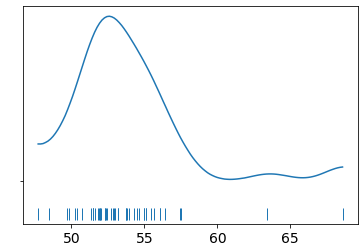

In [ ]:
az.plot_kde(data, rug=True)
plt.yticks([0], alpha=0)

[45.634, 70.666, 10.312458871064944]


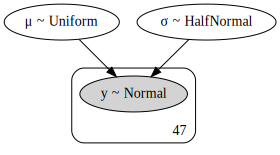

In [ ]:
# We will infer a posterior for the mean and variance.
# We use a uniform prior for the mean, with support slightly larger than the data.
# We use a truncated normal for the variance, with effective support uniform 0 to 3*std.
r = np.max(data)-np.min(data)
min_mu = np.min(data)-0.1*r
max_mu = np.max(data)+0.1*r
prior_std = 3*np.std(data)
print([min_mu, max_mu, prior_std])

with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=min_mu, upper=max_mu)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)

pm.model_to_graphviz(model_g) # show the DAG


In [ ]:
with model_g:
    trace_g = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:01<00:00, 1474.21it/s]


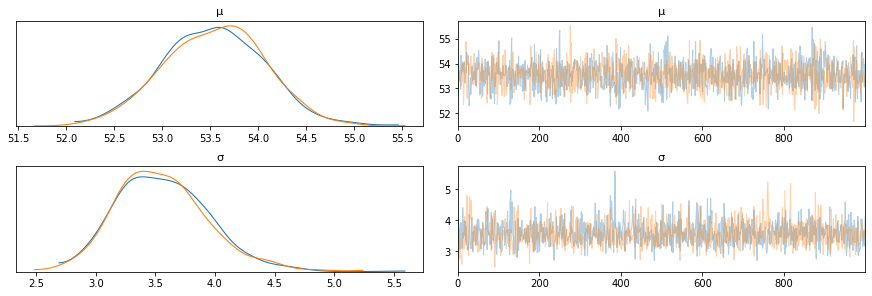

In [ ]:
az.plot_trace(trace_g);

In [ ]:
az.summary(trace_g)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,53.544,0.526,52.549,54.486,0.012,0.008,1929.0,1929.0,1929.0,1423.0,1.0
σ,3.566,0.387,2.835,4.266,0.010,0.008,1366.0,1297.0,1438.0,1157.0,1.0


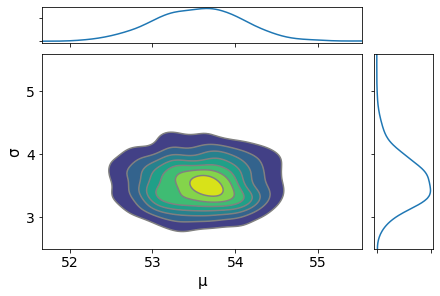

In [ ]:
az.plot_joint(trace_g, kind='kde', fill_last=False);

## Posterior predictive checks

In [ ]:
# We check how well the gaussian assumption fits our data
# by sampling from the fitted model, and plotting the samples
# and the original data.
# For details, see https://docs.pymc.io/notebooks/posterior_predictive.html

# For the Gaussian model, the mean and variance is higher than for the observed data, 
# indicating poor fit.
y_pred_g = pm.sample_posterior_predictive(trace_g, 100, model_g)

print(y_pred_g.keys())
v=y_pred_g['y']
print(type(v))
print(v.shape) # 100 x 47






/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 100/100 [00:00<00:00, 1094.21it/s]

dict_keys(['y'])
<class 'numpy.ndarray'>
(100, 47)


arviz.data.io_pymc3 - WARNING - posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


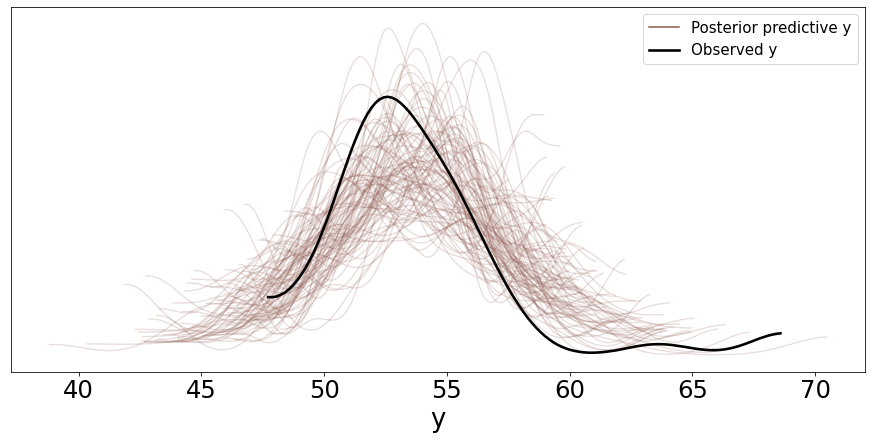

In [ ]:
data_ppc = az.from_pymc3(trace=trace_g, posterior_predictive=y_pred_g)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False);
ax[0].legend(fontsize=15)

## Robust likelihood (1d Student distribution)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ν, σ, μ]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:01<00:00, 857.23it/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,53.077,0.388,52.340,53.774,0.010,0.007,1365.0,1365.0,1366.0,867.0,1.0
σ,2.188,0.403,1.507,2.977,0.012,0.009,1043.0,1043.0,1035.0,1275.0,1.0
ν,4.500,3.510,1.270,9.556,0.115,0.081,933.0,933.0,1095.0,1125.0,1.0


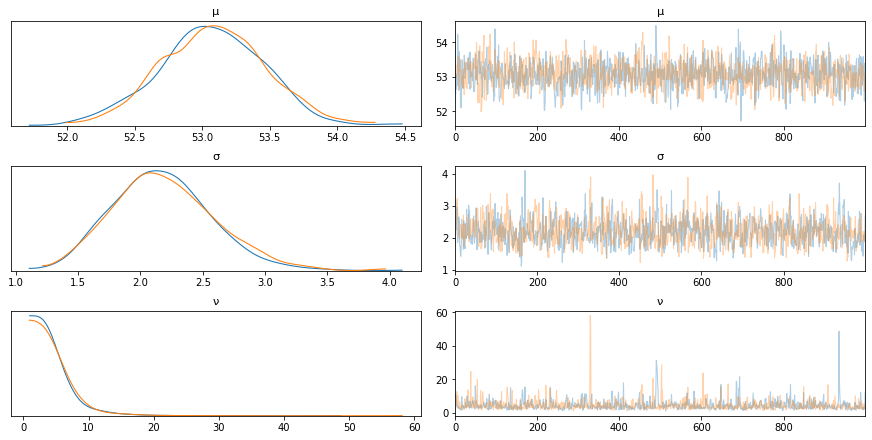

In [ ]:
# We replace the above Gaussian likelihood with a Student t distribution.
# The degree of freedom parameter \nu > 0 (also called the "normality parameter")
# determines how close to Normal the distribution is.
# nu=1 corredsponds to a Cauchy, nu >> 10 corresponds to a Gaussian.
# We put an Exponential prior on nu, with a mean of 30.

with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sd=10)
    ν = pm.Exponential('ν', 1/30) # PyMC3 uses inverse of the mean
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=data)

pm.model_to_graphviz(model_t) # show the DAG

with model_t:
    trace_t = pm.sample(1000)

az.plot_trace(trace_t)

az.summary(trace_t)
# We see that E[nu]=4.5, which is fairly far from Gaussian
# We see E[sigma]=2.1, wich is less than the 3.5 estimate from Gaussian likelihood


/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 100/100 [00:00<00:00, 1055.67it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


(40.0, 70.0)

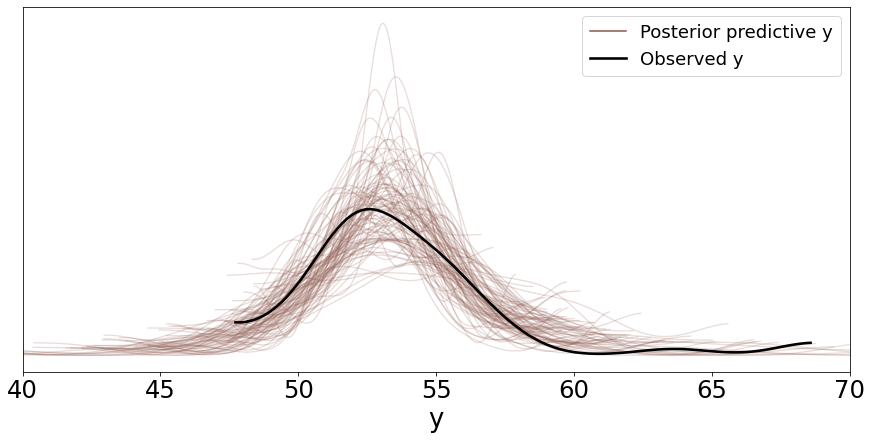

In [ ]:
# posterior predictive check

y_ppc_t = pm.sample_posterior_predictive(
    trace_t, 100, model_t, random_seed=123)
y_pred_t = az.from_pymc3(trace=trace_t, posterior_predictive=y_ppc_t)
az.plot_ppc(y_pred_t, figsize=(12, 6), mean=False)
ax[0].legend(fontsize=15)
plt.xlim(40, 70)

In [ ]:
# Remove outliers from data and compare empirical mean and variance of cleaned data
# to posterior mean and posterior scale of a Student likelihood

# https://gist.github.com/vishalkuo/f4aec300cf6252ed28d3
def removeOutliers(x, outlierConstant=1.5):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    result = a[np.where((a >= quartileSet[0]) & (a <= quartileSet[1]))]
    return result.tolist()

data_clean = removeOutliers(data)
mu_mcmc = np.mean(trace_t.get_values('μ'))
sigma_mcmc = np.mean(trace_t.get_values('σ'))

print([np.mean(data), np.mean(data_clean), mu_mcmc])
print([np.std(data), np.std(data_clean), sigma_mcmc])


[53.548297872340434, 52.994666666666674]
[3.4374862903549817, 2.200877198856048]


# Comparing means of different datasets

We often want to know if one dataset, $D_i$,  has a "statistically signficant" difference in one of its parameters, such as its mean $\mu_i$, compared to some other dataset, $D_j$. We can answer this in a Bayesian way by computing $p(\delta_{ij}|D_i,D_j)$, where

$\delta_{ij}=\mu_i-\mu_j$.

To do this, we draw samples from $p(\mu_i|D_i)$ and $p(\mu_j|D_j)$.

Since the magnitude of $\delta_{ij}$ can be hard to interpret, it is common to divide it by the pooled standard deviation, to get a metric known as Cohen's d (see [this website](https://rpsychologist.com/d3/cohend/) for details):

$d_{ij} = \frac{\mu_j - \mu_i}{\sqrt{\frac{\sigma_i^2 + \sigma_j^2}{2}}}$

We can compute $p(d_{ij}|D_i,D_j)$ using posterior samples of $\mu_i,\mu_j,\sigma_i,\sigma_j$.








In [ ]:
#We illustrate this below using the same dataset as used in chap 2 of
#["Bayesian Analysis with Python (2nd end)"](https://github.com/aloctavodia/BAP) that records how much tips waiters made.

url = 'https://raw.githubusercontent.com/aloctavodia/BAP/master/code/data/tips.csv'
df = pd.read_csv(url)
df.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


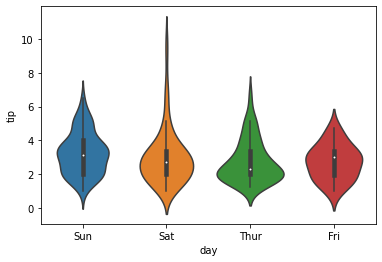

In [ ]:
# We look at the effect of day on tip amount.
# We ignore other covariates, such as gender.

sns.violinplot(x='day', y='tip', data=df)


In [ ]:
# We will compute 4 groups, corresponding to Thur-Sun.
x=df['day'].values
print(type(x))
print(x)
print(np.unique(x))

<class 'numpy.ndarray'>
['Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun'
 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat'
 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat'
 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun'
 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Sat' 'Sat' 'Sat' 'Sat'
 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat'
 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur'
 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Fri' 'Fri' 'Fri' 'Fri'
 'Fri' 'Fri' 'Fri' 'Fri' 'Fri' 'Fri' 'Fri' 'Fri' 'Sat' 'Sat' 'Sat' 'Sat'
 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sat' 'Sun' 'Sun' 'Sun' 'Sun' 'Sun' 'Thur'
 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur'
 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur'
 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur' 'Thur'
 'Thur' 'Thur' 'Sun' 'Sun' 'Sun

In [ ]:
tip_amount = df['tip'].values
days = ['Thur', 'Fri', 'Sat', 'Sun']
#idx = pd.Categorical(tips['day'], categories=days).codes
idx = pd.Categorical(df['day'], categories=days).codes 
ngroups = len(np.unique(idx))
print(idx)

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2
 2 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1
 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[μ, σ_log__, y]


Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ]
Sampling chain 1, 0 divergences: 100%|██████████| 5500/5500 [00:05<00:00, 1042.98it/s]
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ[0],2.770,0.162,2.465,3.073,0.001,0.001,11833.0,11830.0,11878.0,8000.0,1.0
μ[1],2.734,0.254,2.257,3.209,0.002,0.002,10489.0,10466.0,10546.0,7271.0,1.0
μ[2],2.992,0.178,2.655,3.325,0.002,0.001,11232.0,11219.0,11266.0,7791.0,1.0
μ[3],3.254,0.142,2.983,3.516,0.001,0.001,11544.0,11539.0,11574.0,7838.0,1.0
σ[0],1.265,0.118,1.042,1.484,0.001,0.001,11600.0,11215.0,11988.0,7661.0,1.0
σ[1],1.094,0.194,0.756,1.444,0.002,0.001,9626.0,8945.0,10104.0,7420.0,1.0
σ[2],1.656,0.131,1.418,1.904,0.001,0.001,10875.0,10468.0,11369.0,7061.0,1.0
σ[3],1.255,0.105,1.061,1.443,0.001,0.001,12919.0,12426.0,13159.0,7516.0,1.0


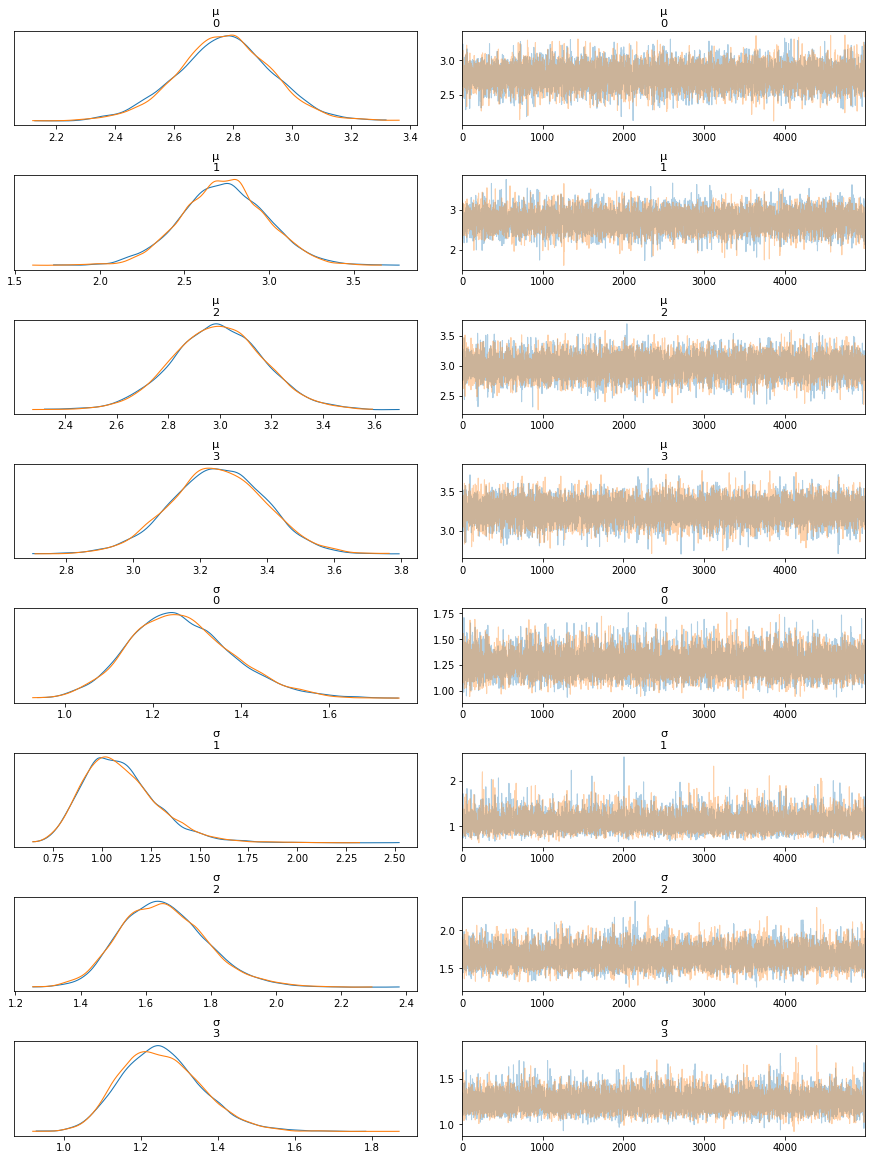

In [ ]:
with pm.Model() as model_cg:
    μ = pm.Normal('μ', mu=0, sd=10, shape=ngroups)
    σ = pm.HalfNormal('σ', sd=10, shape=ngroups)
    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=tip_amount)

print(model_cg.basic_RVs)

with model_cg:
    trace_cg = pm.sample(5000)

az.plot_trace(trace_cg)
az.summary(trace_cg)

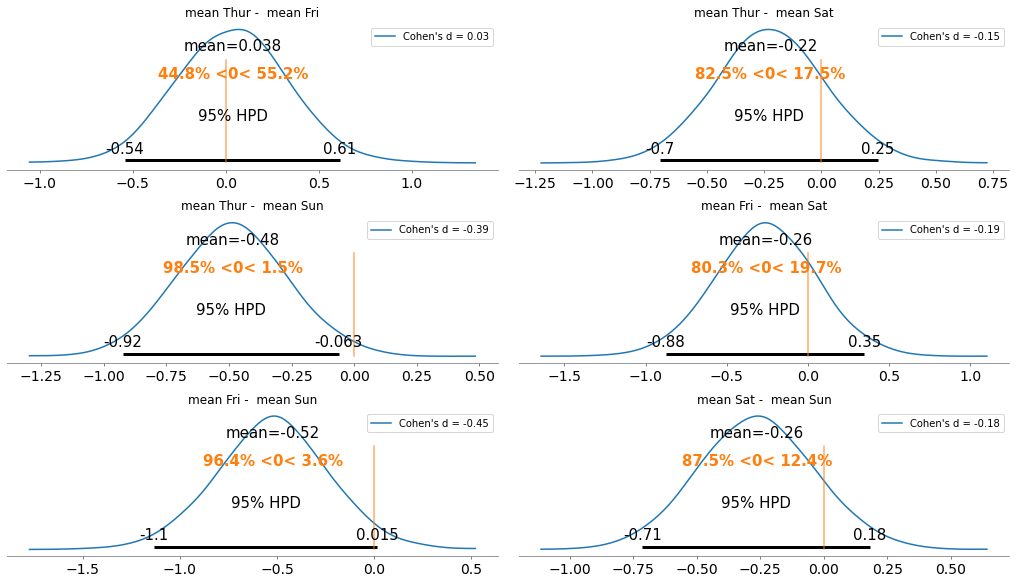

In [ ]:
# Looking at the posterior mean for the mu_i,
# we see Thur ~ Fri < Sat < Sun.
# But to see if these differences are significant, we should take
# into account the variability. We illustrate this below.
# We see that Thursday and Friday both earn significantly less than Sunday.
# (The threshold of 0 is outside the 95% HPD).
# Other differences are less significant.

fig, ax = plt.subplots(3, 2, figsize=(14, 8), constrained_layout=True)

comparisons = [(i, j) for i in range(ngroups) for j in range(i+1, ngroups)]
pos = [(k, l) for k in range(ngroups-1) for l in (0, 1)] # position of plot

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = trace_cg['μ'][:, i] - trace_cg['μ'][:, j]
    d_cohen = (means_diff / np.sqrt((trace_cg['σ'][:, i]**2 + trace_cg['σ'][:, j]**2) / 2)).mean()
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l],  credible_interval=0.95)
    name_i = days[i]
    name_j = days[j]
    str = 'mean {} -  mean {}'.format(name_i, name_j)
    ax[k, l].set_title(str)
    ax[k, l].plot(0, label=f"Cohen's d = {d_cohen:.2f}")
    ax[k, l].legend()
